In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from skopt import BayesSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
import pickle

## Read data

In [2]:
df_mad_ded = pd.read_csv('../data-csv/data_madrid_ded.csv')
print('Shape:', df_mad_ded.shape)
df_mad_ded.sort_values(by=['ASSETID', 'PERIOD', 'PRICE'], ascending=[True, False, True]).head(10)

Shape: (75804, 40)


,ASSETID,PERIOD,PRICE,UNITPRICE,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,...,CADMAXBUILDINGFLOOR,CADDWELLINGCOUNT,CADASTRALQUALITYID,BUILTTYPEID_1,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_MAIN,CITY
0,1,201809,255000.0,2628.865979,97,3,2,0,1,0,...,7,8,6,0,0,1,7.829495,0.254412,3.027988,MADRID
1,2,201806,82000.0,1322.580645,62,2,1,0,1,0,...,5,11,7,0,1,0,6.435241,0.268472,4.693939,MADRID
2,3,201803,133000.0,1985.074627,67,3,1,1,0,1,...,5,17,7,0,0,1,4.836415,1.061146,2.623258,MADRID
3,4,201803,204000.0,1133.333333,180,3,2,0,1,1,...,4,13,6,0,0,1,4.664784,0.427977,3.131739,MADRID
4,5,201812,161000.0,2981.481481,54,2,1,0,0,1,...,3,7,6,0,0,1,4.063119,0.377045,2.702218,MADRID
5,6,201803,230000.0,8214.285714,28,1,1,0,1,1,...,6,13,3,0,0,1,0.241875,0.291301,1.070058,MADRID
6,7,201806,78000.0,1368.421053,57,3,1,0,0,1,...,6,25,6,0,1,0,7.269907,0.280549,4.381209,MADRID
7,8,201812,396000.0,3046.153846,130,4,2,1,1,0,...,7,87,4,0,0,1,6.453848,0.604400,5.262124,MADRID
8,9,201809,260000.0,3095.238095,84,1,1,0,1,1,...,8,98,4,0,0,1,1.560128,0.336041,1.579208,MADRID
9,10,201803,280000.0,2800.000000,100,3,2,0,1,1,...,7,203,4,0,0,1,9.142658,0.176679,8.008129,MADRID


In [3]:
target_col = 'PRICE'
predict_cols = ['CONSTRUCTEDAREA',
                'ROOMNUMBER', 'BATHNUMBER', 'HASTERRACE', 'HASLIFT',
                'HASAIRCONDITIONING', 'AMENITYID', 'HASPARKINGSPACE',
                'ISPARKINGSPACEINCLUDEDINPRICE', 'PARKINGSPACEPRICE',
                'HASNORTHORIENTATION', 'HASSOUTHORIENTATION', 'HASEASTORIENTATION',
                'HASWESTORIENTATION', 'HASBOXROOM', 'HASWARDROBE', 'HASSWIMMINGPOOL',
                'HASDOORMAN', 'HASGARDEN', 'ISDUPLEX', 'ISSTUDIO', 'ISINTOPFLOOR',
                'CONSTRUCTIONYEAR', 'FLOORCLEAN',
                'CADCONSTRUCTIONYEAR', 'CADMAXBUILDINGFLOOR', 'CADDWELLINGCOUNT',
                'CADASTRALQUALITYID', 'BUILTTYPEID_1', 'BUILTTYPEID_2', 'BUILTTYPEID_3',
                'DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO', 'DISTANCE_TO_MAIN']

y = df_mad_ded[target_col]
X = df_mad_ded[predict_cols]

print('y shape:', y.shape)
print('X shape:', X.shape)

y shape: (75804,)
X shape: (75804, 34)


Null value: -2147483648

In [4]:
print('Mean price:', round(y.mean(), 2))
print('Median price:', round(y.median(), 2))
print('Price std:', round(y.std(), 2))

# Interquantile range
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
print('IQR:', IQR)

Mean price: 391497.99
Median price: 258000.0
Price std: 415628.48
IQR: 301000.0


### Train-test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

print('y_train shape:', y_train.shape)
print('X_train shape:', X_train.shape)
print('y_test shape:', y_test.shape)
print('X_test shape:', X_test.shape)


y_train shape: (56853,)
X_train shape: (56853, 34)
y_test shape: (18951,)
X_test shape: (18951, 34)


## Baseline model

In [6]:
# Fit and train model
xgb = XGBRegressor(random_state = 42)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [7]:
# Evaluate
preds = xgb.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print('Baseline MAE:', mae)

Baseline MAE: 66414.79129603051


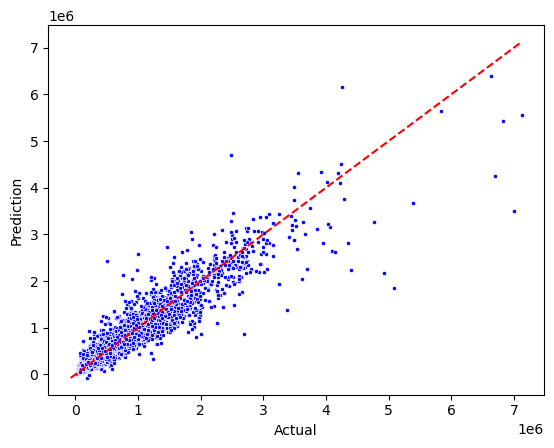

In [8]:
sns.scatterplot(x=y_test, y=preds, marker = '.', color = 'blue')

# Determine the range for the line of equality
min_value = min(min(y_test), min(preds))
max_value = max(max(y_test), max(preds))

# Plot the 45-degree line (line of equality)
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--')

# Show the plot
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()

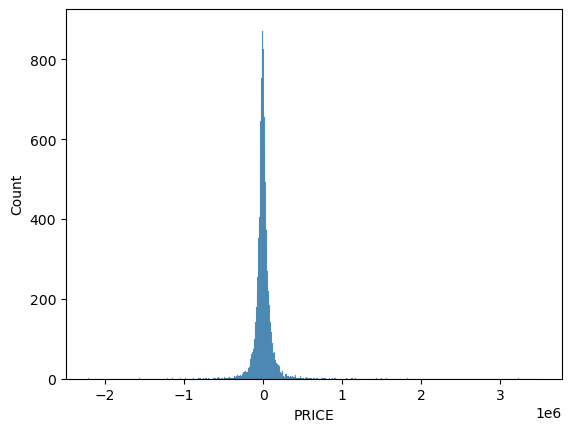

In [9]:
# Residuals
res = y_test - preds
sns.histplot(res)
plt.show()

In [26]:
print('Residuals mean:', round(res.mean(), 2))
print('Residuals standard deviation:', round(res.std(), 2))


Residuals mean: 142.55
Residuals mean: 131258.14


## Hyperparameter tuning with original dataset

In [19]:
# Define the hyperparameter search space
param_space = {
    'max_depth': (3, 10),              # integer values from 3 to 10
    'gamma': (0.0, 0.5),               # float values from 0.0 to 0.5
    'colsample_bytree': (0.5, 1.0),    # float values from 0.5 to 1.0
    'learning_rate': (0.01, 0.3),      # float values from 0.01 to 0.3
    'n_estimators': (50, 500),         # integer values from 50 to 500
    'subsample': (0.6, 1.0)            # float values from 0.6 to 1.0
}

# Initialize the XGBRegressor
xgb = XGBRegressor(random_state=42, objective='reg:squarederror', missing = -2147483648)

# Initialize the BayesSearchCV
opt = BayesSearchCV(
    estimator=xgb,
    search_spaces=param_space,
    n_iter=50,  # number of parameter settings that are sampled
    cv=3,       # 3-fold cross-validation
    n_jobs=-1,  # use all available cores
    random_state=42
)

# Fit the model
opt.fit(X_train, y_train)

# Get the best parameters
best_params = opt.best_params_
print("Best hyperparameters:", best_params)

# Best model
best_model = opt.best_estimator_

# Save the model to a file using pickle
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)


Best hyperparameters: OrderedDict([('colsample_bytree', 1.0), ('gamma', 0.0), ('learning_rate', 0.07589656944258877), ('max_depth', 8), ('n_estimators', 500), ('subsample', 0.6)])


In [21]:
# Load model back
with open('xgb_model.pkl', 'rb') as file:
    best_model = pickle.load(file)

In [20]:
best_preds = best_model.predict(X_test)
mae = mean_absolute_error(best_preds, preds)
print('MAE:', mae)

MAE: 30301.186


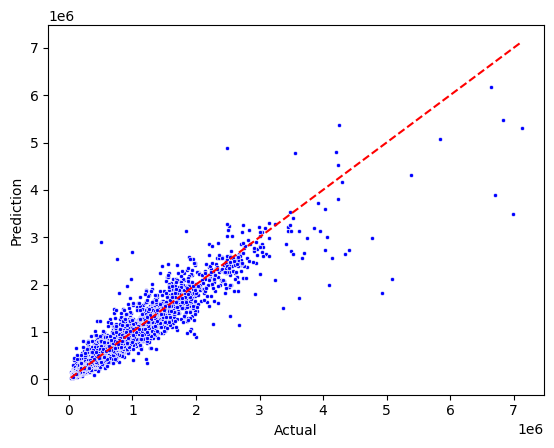

In [22]:
sns.scatterplot(x=y_test, y=best_preds, marker = '.', color = 'blue')

# Determine the range for the line of equality
min_value = min(min(y_test), min(best_preds))
max_value = max(max(y_test), max(best_preds))

# Plot the 45-degree line (line of equality)
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--')

# Show the plot
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()

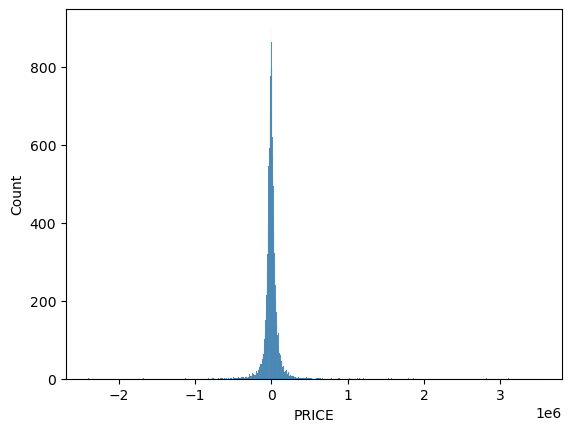

Residuals mean: 825.28
Residuals standard deviation: 122105.1


In [28]:
best_res = y_test - best_preds

sns.histplot(best_res)
plt.show()

print('Residuals mean:', round(best_res.mean(), 2))
print('Residuals standard deviation:', round(best_res.std(), 2))

## Feature engineering